In [ ]:
#https://nbviewer.jupyter.org/github/kellieotto/StatMoments/blob/master/PSM.ipynb
#http://users.nber.org/~rdehejia/nswdata2.html
#https://www.umanitoba.ca/faculties/health_sciences/medicine/units/chs/departmental_units/mchp/protocol/media/propensity_score_matching.pdf

In [5]:
%matplotlib inline
import math
import numpy as np
import scipy
from scipy.stats import binom, hypergeom
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

**Goal:** find the average treatment effect in the treatment group (ATT) on RE78.

**Import the data:** controls and treated from Lalonde/Dehejia papers. Here's what the site says about the data:

The variables from left to right are: treatment indicator (1 if treated, 0 if not treated), age, education, Black (1 if black, 0 otherwise), Hispanic (1 if Hispanic, 0 otherwise), married (1 if married, 0 otherwise), nodegree (1 if no degree, 0 otherwise), RE74 (earnings in 1974), RE75 (earnings in 1975), and RE78 (earnings in 1978).

http://users.nber.org/%7Erdehejia/nswdata2.html

In [74]:
names = ['Treated', 'Age', 'Education', 'Black', 'Hispanic', 'Married',
         'Nodegree', 'RE74', 'RE75', 'RE78']
treated = pd.read_table('nswre74_treated.txt', sep = '\s+',
                        header = None, names = names)
control = pd.read_table('nswre74_control.txt', sep='\s+', 
                        header = None, names = names)
data = pd.concat([treated, control])

#data['Treated']=data['Treated'].map(int)
#data['Age']=data['Age'].map(int)
#data['Education']=data['Education'].map(int)
#data['Black']=data['Black'].map(int)
#data['Hispanic']=data['Hispanic'].map(int)
#data['Married']=data['Married'].map(int)
#data['Nodegree']=data['Nodegree'].map(int)

data

,Treated,Age,Education,Black,Hispanic,Married,Nodegree,RE74,RE75,RE78
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000,0.00,9930.0460
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000,0.00,3595.8940
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000,0.00,24909.4500
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000,0.00,7506.1460
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000,0.00,289.7899
...,...,...,...,...,...,...,...,...,...,...
255,0.0,21.0,9.0,1.0,0.0,0.0,1.0,31886.430,12357.22,0.0000
256,0.0,28.0,11.0,1.0,0.0,0.0,1.0,17491.450,13371.25,0.0000
257,0.0,29.0,9.0,0.0,1.0,0.0,1.0,9594.308,16341.16,16900.3000
258,0.0,25.0,9.0,1.0,0.0,1.0,1.0,24731.620,16946.63,7343.9640


**Compute propensity scores** to start. Then we need to separate the treated and controls again (preserve original indexing) in order to match them.

Note, this section might need some fine-tuning to make it match Dehejia and Wahba (see their appendix for how they computed propensity scores)

In [75]:
propensity = LogisticRegression()
propensity = propensity.fit(data[names[1:-1]], data.Treated)
pscore = propensity.predict_proba(data[names[1:-1]])[:,1] # The predicted propensities by the model
print(pscore[:5])

data['Propensity'] = pscore
#pscore = pd.Series(data = pscore, index = data.index)

[0.42881372 0.31574783 0.55398467 0.37606796 0.39269544]


Implement one-to-one matching, caliper without replacement. Variants of the method are examined in the following paper. This is something to explore further. Austin, P. C. (2014), A comparison of 12 algorithms for matching on the propensity score. Statist. Med., 33: 1057–1069. doi: 10.1002/sim.6004

In [169]:
def Match(groups, propensity, caliper = 0.05):
    ''' 
    Inputs:
    groups = Treatment assignments.  Must be 2 groups
    propensity = Propensity scores for each observation.
    Propensity and groups should be in the same order (matching indices)
    caliper = Maximum difference in matched propensity scores. For now, this is a caliper on the raw
            propensity; Austin reccommends using a caliper on the logit propensity.
    
    Output:
    A series containing the individuals in the control group matched to the treatment group.
    Note that with caliper matching, not every treated individual may have a match.
    '''

    # Check inputs
    if any(propensity <=0) or any(propensity >=1):
        raise ValueError('Propensity scores must be between 0 and 1')
    elif not(0<caliper<1):
        raise ValueError('Caliper must be between 0 and 1')
    elif len(groups)!= len(propensity):
        raise ValueError('groups and propensity scores must be same dimension')
    elif len(groups.unique()) != 2:
        raise ValueError('wrong number of groups')
        
        
    # Code groups as 0 and 1
    groups = groups == groups.unique()[0]
    N = len(groups)
    N1 = groups.sum()
    N2 = N-N1
    g1, g2 = propensity[comparison == 1], (propensity[comparison == 0])
    # Check if treatment groups got flipped - treatment (coded 1) should be the smaller
    if N1 > N2:
        N1, N2, g1, g2 = N2, N1, g2, g1 
        
        
    # Randomly permute the smaller group to get order for matching
    morder = np.random.permutation(N1)
    matches = pd.Series(np.empty(N1))
    matches[:] = np.nan
    
    for m in morder:
        dist = abs(g1[m] - g2)
        if dist.min() <= caliper:
            matches[m] = dist.argmin()
            if matches[m] in g2:
                g2 = g2.drop(int(matches[m]))
    return (matches)

In [173]:
stuff = Match(data['Treated'], data['Propensity'])
g1, g2 = data.Propensity[data.Treated==1], data.Propensity[data.Treated==0]
# test ValueError
#badtreat = data.Treated + data.Hispanic
#Match(badtreat, pscore)
stuff[:5]


0      2.0
1    113.0
2     68.0
3     91.0
4     46.0
dtype: float64

**Here's the result:** if we put the propensity scores of the treatment and matched controls side-by-side, we see that they're matched pretty well.

In [174]:
list(zip(g1, g2[stuff]))

[(0.4288137181417487, 0.3614632308163332),
 (0.31574783218373165, 0.3721279905566081),
 (0.553984672490622, 0.37606796091907096),
 (0.37606796091907096, 0.5900633417259213),
 (0.39269543560833275, 0.3644939775088171),
 (0.3614632308163332, 0.31272293608914403),
 (0.5328379271007886, 0.3647093996215357),
 (0.39045882732785586, 0.5206959104031487),
 (0.5307319720631061, 0.384768772936429),
 (0.5930474759140238, 0.4051352845998035),
 (0.35307462732320666, 0.5335939702483684),
 (0.5270026739562245, 0.5272344593830354),
 (0.3500865252891679, 0.3703707509526879),
 (0.3990565063298883, 0.367319382976401),
 (0.347110143153397, 0.34588275910023886),
 (0.3532870522902832, 0.4051352845998035),
 (0.545171751789351, 0.3789295882155393),
 (0.3644939775088171, 0.3644939775088171),
 (0.5838404234731203, 0.3532870522902832),
 (0.5419197687864946, 0.42528530892196714),
 (0.3647093996215357, 0.3697204549444593),
 (0.5934037332598169, 0.5900633417259213),
 (0.413692729229419, 0.572052985633004),
 (0.36753

__________

In [264]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


def match_samples(treatment, control, mode='propensity_abs', caliper=0.05):
    '''
    :param X: DataFrame containing control and treatment samples. shape: (num_samples, num_features)
    :param y: Series containing corresponding treatment flag for each sample, 1: treatment sample, 0: control sample.
              shape: (num_samples,)
    :param mode: 'propensity_abs': matching to the control sample to which there is the smallest absolute difference
                                   in propensity, where propensity is estimated with a logistic regression
                 'propensity_mbis': (not implemented yet) matches to sample with closest mahalanobis distance, from
                                    subset of control samples that have an absolute difference specified by 'caliper'
                 'nn': treatment matched to the nearest neighbour in the feature space, using sklearn's NearestNeighbors
    :param caliper: 'propensity_abs' mode: maximum difference in matched propensity scores for a valid match to be made
                    'mahalanobis' mode: maximum difference in propensity score, used to create a subset of samples
                                        for which to compare the Mahalanobis distance.
    :return: numpy array, shape: (num_samples, 2). Column 1 gives row number of treatment sample, column 2 gives row
             number of matched control sample. Column 2 value is nan if no match was found within the maximum distance
             specified by caliper, if applicable.
    '''

    # check inputs
    if not (0 < caliper < 1):
        raise ValueError('Caliper must be between 0 and 1')
    num_samples_treatment, num_features_treatment = treatment.shape
    num_samples_control, num_features_control = control.shape
    if not (num_samples_treatment <= num_samples_control):
        raise ValueError('Treatment sample pool must not be bigger than control sample pool.')
    if not (num_features_treatment == num_features_control):
        raise ValueError('Treatment and control must have the same number of features.')
    mode_options = ['propensity_abs', 'propensity_mbis', 'nn']
    if mode not in mode_options:
        raise ValueError('Do not recognise value ' + str(mode) + ' for mode. ' +
                         'Accepted values: ' + str(mode_options) + '.')

    # elif not X.index.is_unique():
    #     raise ValueError('Index of X argument must have unique values')
    # elif not X.index.equals(y.index):
    #     raise ValueError('Index of X and y arguments must be the same')

    # convert inputs to numpy array if necessary
    if isinstance(treatment, pd.DataFrame):
        treatment = treatment.values
    if isinstance(control, pd.DataFrame):
        control = control.values


    # initialise array for matches
    matches = np.vstack([np.arange(num_samples_treatment), np.full(num_samples_treatment, np.nan)]).T

    if mode in ['propensity_abs', 'propensity_mbis']:
        # merge control and treatment for logistic regression
        y = np.append(np.ones(num_samples_treatment), np.zeros(num_samples_control))
        X = np.append(treatment, control, axis=0)

        # generate propensity scores using logistic regression
        propensity_model = LogisticRegression()
        propensity_model = propensity_model.fit(X, y)
        p_score = propensity_model.predict_proba(X)[:, 1]  # estimate probability that sample is treatment from log-reg

        # split p_score into control and treatment
        mask_treatment = (y == 1)  # mask to be used to retrieve only treatment samples
        p_treatment = p_score[mask_treatment]  # array containing pscore for only treatment samples
        p_control = p_score[~mask_treatment]  # array containing pscore for only control samples
        idx_control = np.arange(num_samples_control)  # to keep track of original index when deleting chosen control samples

        if mode =='propensity_abs':
            for i in range(num_samples_treatment):  # for each treatment sample
                dist = np.abs(p_control - p_treatment[i])  # find distance to p_score of all control samples
                j = np.argmin(dist)  # save index of smallest distance
                if dist[j] <= caliper:
                    matches[i, 1] = idx_control[j]  # save index of matched control sample
                    p_control = np.delete(p_control, j, 0)  # remove sample for next iteration
                    idx_control = np.delete(idx_control, j, 0)  # remove sample for next iteration
        elif mode == 'propensity_mbis':
            # not coded yet
            raise RuntimeError('Error: mode \'mahalanobis\' is not written yet, please use mode \'standard\'.')
    elif mode == 'nn':
        neighbours = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control)  # fit model to control samples
        distances, indices = neighbours.kneighbors(treatment)  # find nearest control sample to each treatment sample
        indices = indices.reshape(indices.shape[0])  # reshape to 1D array
        matches[:, 1] = indices  # save index of each control sample into matches output

    return matches.astype(int)


In [265]:

# demonstrator code

treated = pd.DataFrame()
np.random.seed(42)

num_samples_treatment = 200
num_samples_control = 1000
treated['x'] = np.random.normal(0, 1, size=num_samples_treatment)
treated['y'] = np.random.normal(50, 20, size=num_samples_treatment)
treated['z'] = np.random.normal(0, 100, size=num_samples_treatment)

control = pd.DataFrame()
# two different populations
control['x'] = np.append(np.random.normal(0, 3, size=num_samples_control),
                         np.random.normal(-1, 2, size=2 * num_samples_control))
control['y'] = np.append(np.random.normal(50, 30, size=num_samples_control),
                         np.random.normal(-100, 2, size=2 * num_samples_control))
control['z'] = np.append(np.random.normal(0, 200, size=num_samples_control),
                         np.random.normal(13, 200, size=2 * num_samples_control))


In [266]:
treated

,x,y,z
0,0.496714,57.155747,-159.442766
1,-0.138264,61.215691,-59.937502
2,0.647689,71.661025,0.524370
3,1.523030,71.076041,4.698059
4,-0.234153,22.446613,-45.006547
...,...,...,...
195,0.385317,40.616487,-51.001640
196,-0.883857,15.737309,-26.987494
197,0.153725,77.077447,-97.876372
198,0.058209,47.709203,-44.429326


In [267]:
control

,x,y,z
0,2.270966,25.281935,-257.896117
1,-2.766496,28.426716,11.689896
2,2.608818,111.494363,182.524065
3,4.066914,50.020485,84.343387
4,1.240305,73.463900,-11.930862
...,...,...,...
2995,1.292882,-97.343668,-77.289078
2996,-2.946758,-101.008596,-181.565579
2997,1.014267,-101.215648,5.487298
2998,-0.327710,-103.530775,126.951784


In [276]:
# match
matchings = match_samples(treated, control, mode='propensity_abs')

In [277]:
control_matched = control.iloc[matchings[:, 1], :]  # extract matched control samples

(-1, 2)

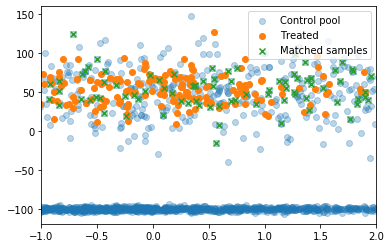

In [278]:
# fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(control['x'], control['y'], alpha=0.3, label='Control pool')
plt.scatter(treated['x'], treated['y'], label='Treated')
plt.scatter(control_matched['x'], control_matched['y'], marker='x', label='Matched samples')
plt.legend()
plt.xlim(-1, 2)

_______

In [273]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def get_matching_pairs(treated_df, non_treated_df, scaler=True):

    treated_x = treated_df.values
    non_treated_x = non_treated_df.values
    if scaler == True:
        scaler = StandardScaler()
    if scaler:
        scaler.fit(treated_x)
        treated_x = scaler.transform(treated_x)
        non_treated_x = scaler.transform(non_treated_x)

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(non_treated_x)
    distances, indices = nbrs.kneighbors(treated_x)
    indices = indices.reshape(indices.shape[0])
    matched = non_treated_df.loc[indices]
    return matched

(-1, 2)

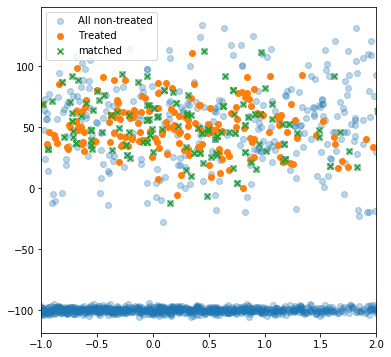

In [274]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

treated_df = pd.DataFrame()
np.random.seed(1)

size_1 = 200
size_2 = 1000
treated_df['x'] = np.random.normal(0,1,size=size_1)
treated_df['y'] = np.random.normal(50,20,size=size_1)
treated_df['z'] = np.random.normal(0,100,size=size_1)

non_treated_df = pd.DataFrame()
# two different populations
non_treated_df['x'] = list(np.random.normal(0,3,size=size_2)) + list(np.random.normal(-1,2,size=2*size_2))
non_treated_df['y'] = list(np.random.normal(50,30,size=size_2)) + list(np.random.normal(-100,2,size=2*size_2))
non_treated_df['z'] = list(np.random.normal(0,200,size=size_2)) + list(np.random.normal(13,200,size=2*size_2))


matched_df = get_matching_pairs(treated_df, non_treated_df)

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(non_treated_df['x'], non_treated_df['y'], alpha=0.3, label='All non-treated')
plt.scatter(treated_df['x'], treated_df['y'], label='Treated')
plt.scatter(matched_df['x'], matched_df['y'], marker='x', label='matched')
plt.legend()
plt.xlim(-1,2)